In [103]:
import numpy as np

class get_epsilon_a():
  def __init__(self,T_a,RH):
    if T_a < 100:
      self.T_a = T_a
      self.T_ak = T_a+273.15
    else:
      self.T_ak=T_a
      self.T_a=T_a-273.15
    if RH>1:
      self.RH=RH*.01
    else:
      self.RH=RH
    self.Prata()

  def Prata(self):
    self.Pv_from_RH()
    a = 1.2
    b = 3
    zeta = 46.5*(self.P_v/self.T_ak)
    self.epsilon_a = 1-(1+zeta)*np.exp(-(a+b*zeta)**0.5)

  def Pv_from_RH(self):
    P_v_star = 6.112*np.exp(17.62*self.T_a/(243.12+self.T_a))
    self.P_v = self.RH*P_v_star
e = get_epsilon_a(9,80)

In [26]:
Ca = 1210 # J m-3 K-1

z1 = 1 #m.a.g.l
z2 = 100 #m.a.g.l
Delta_z = z2-z1

Rn_z1 = 150 #Wm-2
Rn_z2 = 151 #Wm-2

t1 = 12 # 12:00 P.M.
t2 = 12.5 # 12:30 P.M.
Delta_t = (t2-t1)*3600 # Convert to seconds: 1 W = 1 J s-1

Delta_Rn = Rn_z2 - Rn_z1
Delta_Ta = Delta_Rn/(Ca*Delta_z)*Delta_t
Delta_Ta



0.015026296018031555

In [33]:
import numpy as np
Ca = 1210 # J m-3 K-1

z1 = 1 #m.a.g.l
z2 = 17000 #m.a.g.l
Delta_z = z2-z1

Rn_z1 = 125 #Wm-2
Rn_z2 = -100 #Wm-2

t1 = 0 # 12:00 A.M. (midnight)
t2 = 24 # 12:00 A.M. (midnight *the next day*)
Delta_t = (t2-t1)*3600 # Convert to seconds: 1 W = 1 J s-1

Delta_Rn = Rn_z2 - Rn_z1
Delta_Ta = Delta_Rn/(Ca*Delta_z)*Delta_t

print(f"The net temperature change attributable to radiative cooling is {np.round(Delta_Ta,2)} K")

The net temperature change attributable to radiative cooling is -0.95 K


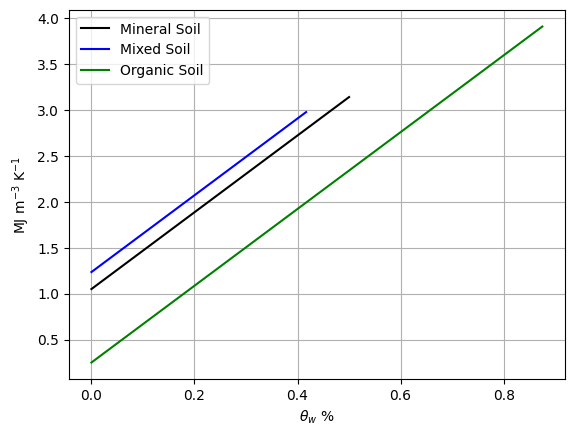

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def get_C(theta_m,theta_o,theta_w):
    C_w,C_m,C_o,C_a = 4.18, 2.1,2.5,0.0012 # MJ m-3 K-1
    theta_a = 1-(theta_m+theta_o+theta_w)
    theta_a[np.where(theta_a<0)]=np.nan # What does this line do?
    C = C_m*theta_m + C_o*theta_o + C_w*theta_w + C_a*theta_a
    return(C)

theta_w = np.linspace(0,1,25)
plt.figure()
plt.plot(theta_w,get_C(.5,0,theta_w),color='black',label='Mineral Soil')
plt.plot(theta_w,get_C(.35,.2,theta_w),color='blue',label='Mixed Soil')
plt.plot(theta_w,get_C(0,.1,theta_w),color='green',label='Organic Soil')
plt.ylabel(r'MJ m$^{-3}$ K$^{-1}$')
plt.xlabel(r'$\theta_w$ %')
plt.grid()
plt.legend()

[0.510572   0.93698397]


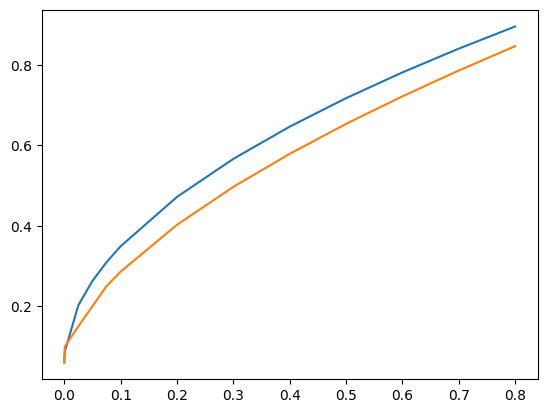

In [84]:

from scipy.optimize import curve_fit

def func(x, a, b):

    return x ** a * b + np.min(x)

df2 = df[['Mineral']].dropna()
popt, pcov = curve_fit(func, df.index, df['Organic'])
popt

fig,ax=plt.subplots()
ax.plot(df.index,df.index**popt[0]*popt[1]+df['Organic'].min())
# ax.plot(df2.index,df2.index**.5+popt[1])
ax.plot(df.index,df.Organic)

print(popt)


# mineral = [0.3282811, 2.38478456]
# organic = [0.510572, 0.93698397]

Text(0, 0.5, '$W m^{-1} K|^{-1}$')

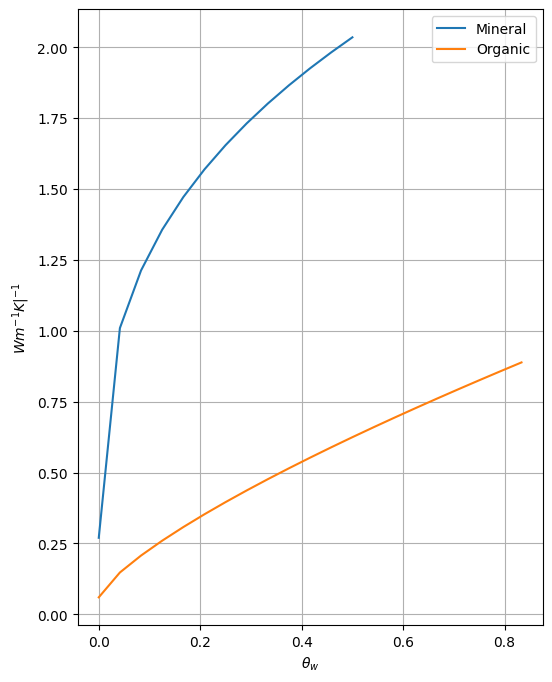

In [108]:

theta_w = np.linspace(0,1,25)

k_mineral = theta_w**0.35* 2.25 + 0.27
k_organic = theta_w**0.75* .95 + 0.06


k_mineral[np.where(theta_w>.5)]=np.nan
k_organic[np.where(theta_w>.85)]=np.nan

fig,ax=plt.subplots(figsize=(6,8))
ax.plot(theta_w,k_mineral,label='Mineral')
ax.plot(theta_w,k_organic,label='Organic')
ax.grid()
ax.legend()
ax.set_xlabel(r'$\theta_w$')
ax.set_ylabel(r'$W m^{-1} K|^{-1}$')

Text(0, 0.5, '$m^2 s^{-1}$')

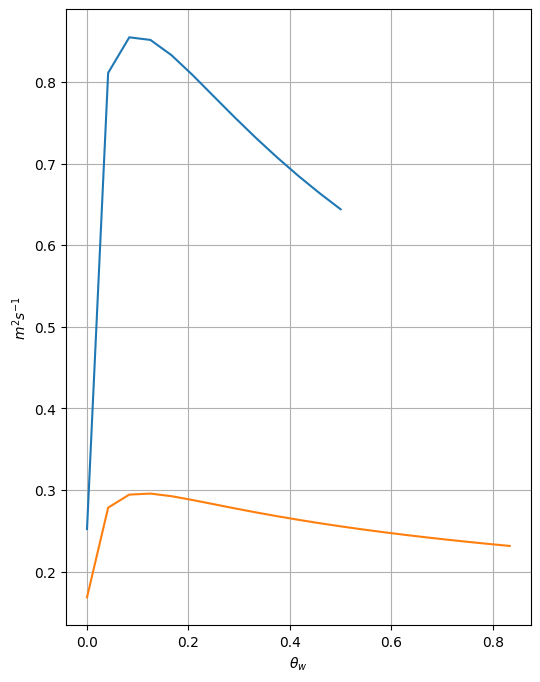

In [109]:

k_mineral[np.where(theta_w>.5)]=np.nan
k_organic[np.where(theta_w>.85)]=np.nan

fig,ax=plt.subplots(figsize=(6,8))
ax.plot(theta_w,k_mineral/get_C(.45,0.05,theta_w),label='Mineral')
ax.plot(theta_w,k_organic/get_C(0.05,.1,theta_w),label='Organic')


ax.grid()
ax.set_xlabel(r'$\theta_w$')
ax.set_ylabel(r'$m^2 s^{-1}$')

In [32]:
# import pandas as pd
import os
out = 'C:/Users/User/Teaching/GEOS300/AssignmentData/WesthamIslandSoilData/'
L = []
for file in os.listdir(out):
    if file.endswith('.txt'):
        L.append(file)
tbl = '''
Last digit of student number | date (YYYMMDD)
-----------------------------|-----\n'''
for i,l in enumerate(L[-11:-1]):
    tbl+=f'{str(i)}|{l.split(".")[0]}\n'
print(tbl)
# for file in os.listdir('../../2023_Assignments/GEOS300/assignment2/data/'):

#         df = pd.read_csv('../../2023_Assignments/GEOS300/assignment2/data/'+file,skiprows=12)
#         cols = [c.replace('"','').replace(' ','') for c in df.columns]
#         df.columns=cols
#         df = df.rename(columns={'QG':'H_g','Q*':'R_n','QG.1':'H'})
#         df['H'] = pd.to_numeric(df['H'],errors='coerce')
#         df['H'] = df['H'].fillna('-9999')
#         df[df.columns[~df.columns.str.contains('Unnamed')]].to_csv(out+file.split('data')[-1],index=False)


Last digit of student number | date (YYYMMDD)
-----------------------------|-----
0|20090614
1|20090630
2|20090701
3|20090702
4|20090711
5|20090716
6|20090721
7|20090729
8|20090730
9|20090802



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# Import the data from github & parse the timestamp for each record
data_url='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/WesthamIslandSoilData/20090324.txt'
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
df = pd.read_csv(data_url,parse_dates=['TIME(PST)'],index_col=['TIME(PST)'],na_values=-9999)

# Use linear interpolation to estimate missing H values where available
df['H_filled'] = df['H'].interpolate()
# Backfill where linear interpolation didn't work (the first observation)
df['H_filled'] = df['H_filled'].bfill()

df.head()


,T_1,T_2,T_3,T_4,H_g,WVC,R_n,H,H_filled
TIME(PST),,,,,,,,,
2009-03-24 00:15:00,0.844,1.110,1.383,1.313,-1.88,0.366,-1.2,NaN,-40.7
2009-03-24 00:30:00,0.822,1.112,1.372,1.307,-1.86,0.367,-1.5,-40.7,-40.7
2009-03-24 00:45:00,0.817,1.089,1.358,1.316,-1.89,0.367,-2.1,NaN,-28.5
2009-03-24 01:00:00,0.797,1.093,1.381,1.330,-1.98,0.367,-2.1,-16.3,-16.3
2009-03-24 01:15:00,0.788,1.060,1.382,1.333,-2.12,0.368,-1.8,NaN,-6.2


In [14]:
# plt.figure()
T_1 = df.iloc[48][['T_1','T_2']].mean()

T_2 = df.iloc[51][['T_1','T_2']].mean()

Delta_T_delta_t = (T_2-T_1)/3600

H_g = df.iloc[48:52]['H_g'].mean()
C = H_g/0.05/Delta_T_delta_t*1e-6
C

2.2962334217506624

In [24]:
df.loc[((df.index.hour<6)|((df.index.hour|6))),'H_g'].sum()*900

410301.0

In [11]:
df.iloc[12*4+1][['T_1','T_2','H_g']]

# 16.770 = -k*(1.981-4.183)/(10-5)

k = -(.10-.05)/(1.981-4.183)*16.770
k
# df.iloc[12*4+1]

0.38079019073569487

In [20]:
df.iloc[12*4:13*4][['T_1','T_2','H_g']].mean()

# 16.770 = -k*(1.981-4.183)/(10-5)

# k = -(.10-.05)/(1.981-4.183)*16.770

T_1 = (4.18+1.98)/2
T_2 = (4.837+2.458)/2

Delta_T=(T_2-T_1)/3600
C_s = 18.03500/.05/Delta_T * 1e-6
C_s

2.288140969162996

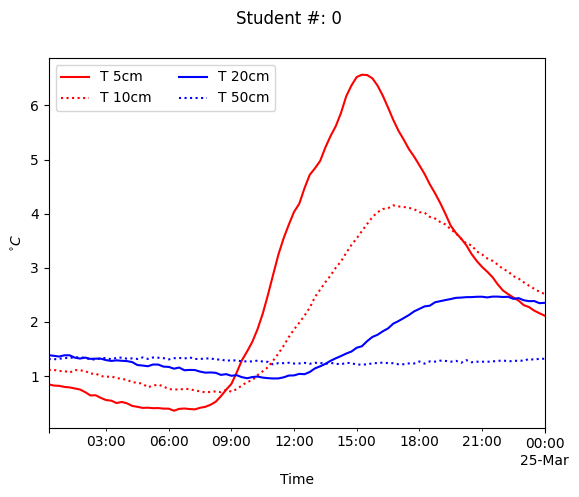

In [3]:
Student_Number = 00000000
fig,ax=plt.subplots()
plt.suptitle(f'Student #: {Student_Number}')
df[['T_1','T_2','T_3','T_4']].plot(ax=ax,
              color=['red','red','blue','blue'],
              style=['-',':','-',':'])
ax.set_ylabel(r'$^{\circ} C$')
ax.set_xlabel('Time')
ax.legend(['T 5cm','T 10cm','T 20cm','T 50cm',],ncol=2)

Text(0.5, 0, 'Time')

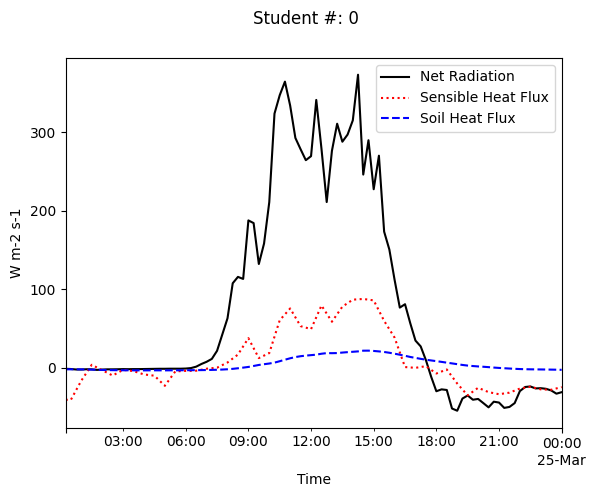

In [4]:
Student_Number = 00000000
fig,ax=plt.subplots()
plt.suptitle(f'Student #: {Student_Number}')
df[['R_n','H_filled','H_g']].plot(ax=ax,
              color=['black','red','blue'],
              style=['-',':','--'])
ax.legend(['Net Radiation','Sensible Heat Flux','Soil Heat Flux'])
ax.set_ylabel('W m-2 s-1')
ax.set_xlabel('Time')

Text(0.5, 1.0, 'Visible Light in Liquid Water')

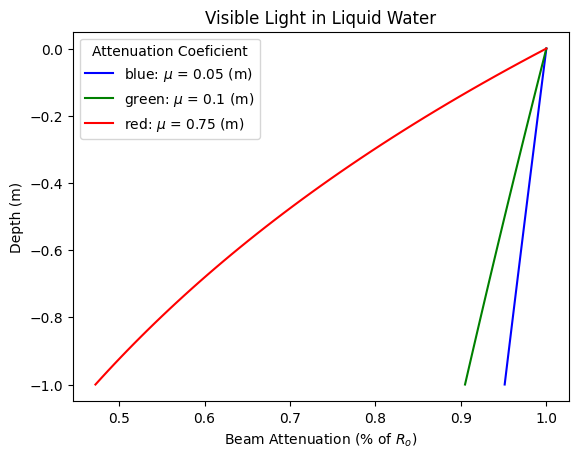

In [49]:
import numpy as np
def Beers_Law (R_0,X,mu):
    R_x = R_0*np.exp(-mu*X)
    return(R_x)

z = np.linspace(0,1)
R_0 = 1

fig,ax=plt.subplots()
for mu,c in zip([0.05,0.1,0.75],
            ['blue','green','red']):
    R_z = Beers_Law(R_0,z,mu)
    ax.plot(R_z,-z,color=c,
            label=f'{c}: $\mu$ = {mu} (m)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Beam Attenuation (% of $R_o$)')
ax.legend(title='Attenuation Coeficient')
ax.set_title('Visible Light in Liquid Water')

In [79]:
import pandas as pd
# import shutil
import os
import numpy as np
data_url='C:/Users/User/Teaching/GEOS300/AssignmentData/KettlemanCityCottonField/'
TimeStamp = '200008191630'
# W_max = []
# for f in os.listdir(data_url):
    # if 'wind' in f:
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
# Turbulence = pd.read_csv(
# f'{data_url}wind{TimeStamp}.txt',skiprows=7,
#     parse_dates={'TIMESTAMP':['YYYY-MM-DD HH:MM:SS']},index_col='TIMESTAMP',na_values=-9999)
Wind = pd.read_csv(f'{data_url}wind{TimeStamp}.txt',skiprows=6,na_values=-9999)
# W_max.append(Wind['Horizontal wind velocity (m/s)'].max())
Wind
# W_max = np.array(W_max)
# print(W_max.max())

,Height (m),Horizontal wind velocity (m/s)
0,0.95,1.77
1,1.55,2.18
2,2.35,2.47
3,3.72,2.85
4,6.15,3.37
5,9.05,3.67


In [33]:
import os
import numpy as np
data_url='C:/Users/User/Teaching/GEOS300/AssignmentData/KettlemanCityCottonField/'
for f in os.listdir(data_url):
    if 'wind' in f:
        with open(data_url+f,'r') as file:
            lines = file.read()
            fbreak = lines.split('\n',7)
            fbreak.pop(6)
            # press = 101.325+np.round((np.random.rand(1)-.5)/2,3)[0]
            # fbreak.insert(5,f'# Air pressure: {press:.3f} kPa')
            txt = ('\n').join(fbreak).replace('Horizontal wind velocity (m/s)','Wind Speed (m/s)')
            print(txt)
        with open(data_url+f,'w') as file2:
            file2.writelines(txt)

# EBEX 2000, Kettleman City, CA, USA
# Wind profile measured by cup anemometers
# Start: 2000/08/02 15:30 PST
# Average values over 30 min
# Air temperature: 34.6 deg C
# Air pressure: 101.250 kPa

"Height (m)","Wind Speed (m/s)"
        0.95,         1.54
        1.55,         1.83
        2.35,         2.00
        3.72,         2.22
        6.15,         2.50
        9.05,         2.72

# EBEX 2000, Kettleman City, CA, USA
# Wind profile measured by cup anemometers
# Start: 2000/08/03 10:00 PST
# Average values over 30 min
# Air temperature: 29.0 deg C
# Air pressure: 101.460 kPa

"Height (m)","Wind Speed (m/s)"
        0.95,         1.19
        1.55,         1.42
        2.35,         1.57
        3.72,         1.76
        6.15,         2.00
        9.05,         2.13

# EBEX 2000, Kettleman City, CA, USA
# Wind profile measured by cup anemometers
# Start: 2000/08/03 10:30 PST
# Average values over 30 min
# Air temperature: 29.8 deg C
# Air pressure: 101.353 kPa

"Height (m)","Wi

1.1751196328367708 -2.0986472898421247
-2.0986472898421247


-0.05129329438755058

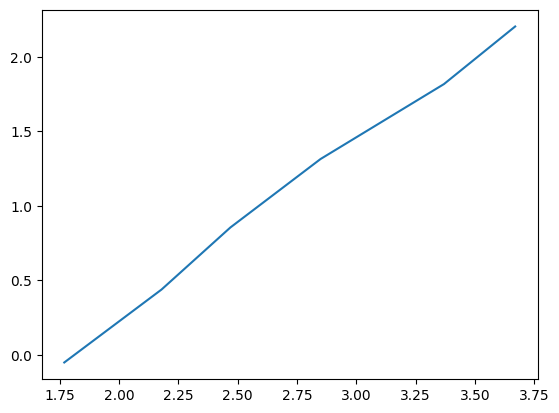

In [77]:
import matplotlib.pyplot as plt
import numpy as np

#y=mx+b > polyfit(x,y,1) will return the slope(m) and intercept(b) of a linear equation
m,b=np.polyfit(Wind['Horizontal wind velocity (m/s)'],np.log(Wind['Height (m)']),1)
print(m,b)
print(m*0+b)
fit,ax=plt.subplots()
ax.plot(Wind['Horizontal wind velocity (m/s)'],np.log(Wind['Height (m)']))

In [85]:
Wind=pd.concat([Wind,
    pd.DataFrame(data={
    'Horizontal wind velocity (m/s)':[0],
    'Height (m)':[1],#Height in m
    'lnz':[1]
    })], ignore_index = True)
Wind

,Height (m),Horizontal wind velocity (m/s),lnz
0,0.95,1.77,NaN
1,1.55,2.18,NaN
2,2.35,2.47,NaN
3,3.72,2.85,NaN
4,6.15,3.37,NaN
5,9.05,3.67,NaN
6,1.00,0.00,1.0


In [74]:
import numpy as np
Wind['lnz'] = np.log(Wind['Height (m)'])
Wind['U'] = Wind['Horizontal wind velocity (m/s)']
np.polyfit(Wind['U'],Wind['lnz'],1)
# np.polyf
# Wind

array([ 1.17511963, -2.09864729])

In [71]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Wind[['Horizontal wind velocity (m/s)']],np.log(Wind['Height (m)']))
reg.coef_
reg.intercept_

-2.0986472898421247

In [12]:
dT_dt = 1.38e-4
C = 2e6
z0 = 0
z1 = 0.05
H1 = 25

dz = z1-z0

# DH = H1-H0
H0 = H1-dT_dt*C*dz
H0

11.2

In [1]:
C_a = 0.001*10**6
T_0 = 1.2
T_a = -0.7
r_b = 55
H = C_a*(T_0-T_a)/r_b
H

34.54545454545455

In [11]:
import pandas as pd
import numpy as np


df=pd.DataFrame(data={
    'Year': [
        2018,
        2019,
        2020,
        2021,
        2022,
        2023,
        2024
    ],
    'Pay': [
        69497,
        70887,
        71950,
        73029,
        np.nan,
        np.nan,
        np.nan
    ]
    }
)
# df['Pay'].interpolate('linear')
df2 = df.dropna()

from scipy.optimize import curve_fit

def func(x, m, b):

    return x * m + b 

popt, pcov = curve_fit(func, df2['Year'], df2['Pay'])
df['Pay'] = popt[0]*df['Year']+popt[1]
df
# popt[0]

,Year,Pay
0,2018,69591.899513
1,2019,70757.799838
2,2020,71923.700162
3,2021,73089.600487
4,2022,74255.500812
5,2023,75421.401137
6,2024,76587.301462


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load a wind profile
profile = pd.read_csv('Data/Profile.csv')
# Calculate ln(z)
profile['lnz']=np.log(profile['z (m)'])
# Find the intercept of a linear fit
m,b=np.polyfit(profile['u (m/s)'],profile['lnz'],1)

# Plot the results
fit,ax=plt.subplots()
profile.plot(x='u (m/s)',y='lnz',ax=ax,marker='*',label='log-profile')
ax.scatter(0,b,marker='*',color='r',label='intercept')
ax.grid()
ax.set_title('Log Wind Profile')
ax.set_ylabel('ln(z)')
ax.set_xlabel('U (m/s)')

   z (m)  u (m/s)
0   0.95     1.77
1   1.55     2.18
2   2.35     2.47
3   3.72     2.85
4   6.15     3.37
5   9.05     3.67


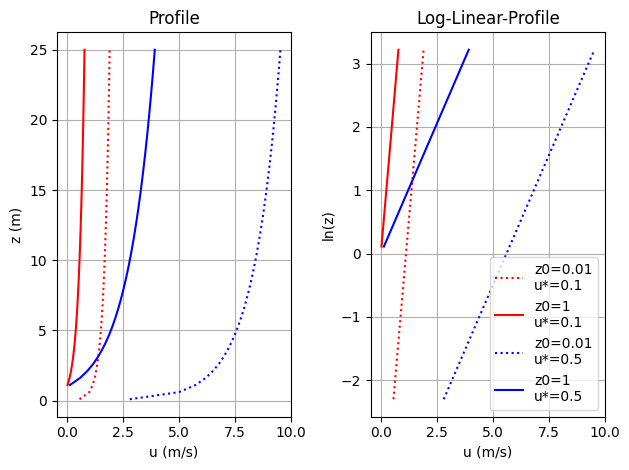

In [65]:
import numpy as np
import matplotlib.pyplot as plt

k = 0.41
# short grass (0.01), trees (1.0)
z0_list = [0.01,1.0] 
# weak winds (0.1), moderately strong winds (0.5)
u_star_list = [0.1,0.5]
# define a height profile
z = np.linspace(0.1,25)
# define a plot and loop through scenarios
fig,ax=plt.subplots(1,2)
for u_star,c in zip(u_star_list,['r','b']):
    for z0,l in zip(z0_list,[':','-']):
        u_bar_z = u_star/k*np.log(z/z0)
        u_bar_z[u_bar_z<0]=np.nan
        ax[0].plot(u_bar_z,z,color=c,linestyle=l)
        ax[1].plot(u_bar_z,np.log(z),label=f'z0={z0}\nu*={u_star}',color=c,linestyle=l)
# format the graph
ax[1].legend()
ax[0].set_ylabel('z (m)')
ax[0].set_title('Profile')
ax[1].set_ylabel('ln(z)')
ax[1].set_title('Log-Linear-Profile')
for a in ax:
    a.set_xlabel('u (m/s)')
    a.grid()
plt.tight_layout()

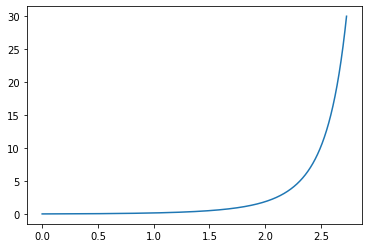

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def get_Phi_M(zeta):
    Phi_M = np.ones(zeta.shape)
    # Stable/Neutral
    Phi_M[zeta>0] = 1 + 4.7 * zeta[zeta>0]
    # Unstable
    Phi_M[zeta<0] = (1 - 15 * zeta[zeta<0])**-0.25
    return (Phi_M)

def integrate_profile(L,u_star,z0,z,step_size = 0.001):
    k = 0.41
    # Create an array of Z values at "step_size" resolution
    Z = np.arange(z0,z,step_size)
    # Calculate stability parameter
    zeta = Z/L
    # Get zeta values
    Phi_M = get_Phi_M(zeta)
    # Get slope wind profile at each z
    dubar_dz = u_star/(k*Z)*Phi_M
    # Integrate by step, starting at z0 where u_bar = 0
    u_bar = np.cumsum(dubar_dz*step_size)-(dubar_dz[0]*step_size)
        
    return(Z,u_bar)



Z,u_bar = integrate_profile(-10,.2,.02,30)
plt.figure()
plt.plot(u_bar,Z)

In [1]:
import os
import pandas as pd
BM = pd.DataFrame()
b = 'C:/highfreq/BB/biomet/'
for d in [2015,2016]:
    BM = pd.concat([BM,pd.read_csv(f'{b}{d}/Biomet.csv',skiprows=[1],parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])])
rv = pd.read_csv('../_Test/Test.csv',parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])
out_dir = '../../AssignmentData/CA_DBB_DailyData/'
in_dir = 'C:/Users/User/Downloads/GEOS300-main(1)/GEOS300-main/assignment4/data/'
for i,f in enumerate(os.listdir(in_dir)):
    if f.endswith('.txt'):
        df = pd.read_csv(in_dir+f,parse_dates=['Date/Time (PST)'],index_col=['Date/Time (PST)'])
        df = df.rename(columns={'Q* (W m-2)':'Rn (W m-2)'})
        df['Pa (kPa)'] = BM.loc[df.index,'Pa_1_1_1'].values
        df['PPFD (micromol m-2 s-1)'] = BM.loc[df.index,'Pa_1_1_1'].values
        df['rv'] = rv.loc[df.index,'h2o_mixing_ratio'].values*1e-3
        # df = df.drop("w'rho_CH4' (microåmol m-2 s-1)",axis=1)
        df.to_csv(out_dir+f)#.replace('.txt','.csv'))

        if df.count().min() < 48:# and i > 1:
            print(f)
        

20160723.txt
20160725.txt
20160726.txt
20160727.txt
20160728.txt
20160731.txt
20160804.txt


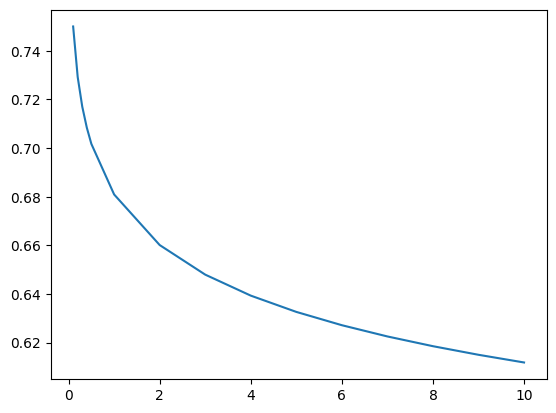

In [9]:
import numpy as np
import matplotlib.pyplot as plt

z02=.1
z01=np.array([0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,6,7,8,9,10])

a = 0.75 + 0.03*np.log(z02/z01)

plt.plot(z01,a)

In [15]:
class Temp_Corrections:
  # Inputs: 
  # Required: T (temp in K), r_v (water vapor mixing ratio in mol/mol), z (height in m)
  # Optional: r_l (mixing ratio of liquid water in mol/mol), z_reff (reference height in m) 
  def __init__(self,T,r_v,z,r_l=0,z_reff=0):
    self.T,self.r_v,self.z = T,r_v,z
    self.r_l,self.z_reff=r_l,z_reff
    self.Potential_Temp()
    self.Virtual_Temp()
    self.summary()
  def Potential_Temp(self):
    DALR = 0.01
    self.Theta = self.T+DALR*(self.z-self.z_reff)
  def Virtual_Temp(self):
    self.T_v = (1 + 0.61 * self.r_v - self.r_l) * self.T
    self.theta_v = (1 + 0.61 * self.r_v - self.r_l) * self.Theta
  def summary(self):
    print(f'Absolute Temp: {self.T:.2f}, Potential Temp: {self.Theta:.2f}, Virtual Temp: {self.T_v:.2f}, Virual Potential Temp: {self.theta_v:.2f}')
    
T_0 = Temp_Corrections(T=283.15,r_v=0,z=0)

Absolute Temp: 283.15, Potential Temp: 283.15, Virtual Temp: 283.15, Virual Potential Temp: 283.15


In [ ]:
# Profile integration



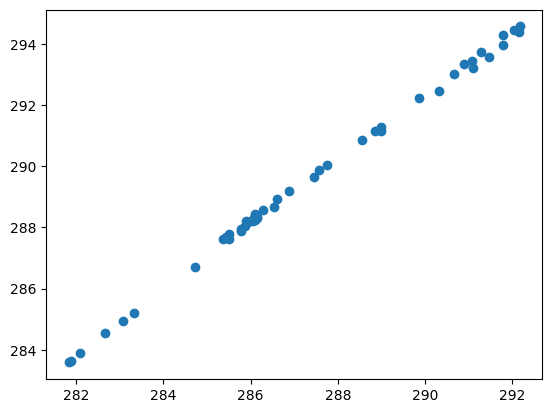

In [17]:
# df['Pa'] = df['Pa (hPa)']*1e3
# df['Pa']

# import numpy as np
# ## Latent heat of vaporization

# # df['Lv']
# T = np.arange(-25,40)
# LV = 2500.8-2.36*T-0.0016*T**2-0.00006*T**3
import matplotlib.pyplot as plt
# plt.plot(T,LV)

df['Tv'] = (1 + 0.61 * df['rv']) * df['T_2m (K)']

plt.scatter(df['T_2m (K)'],df['Tv'])

In [11]:
import geopandas as gpd
fp = gpd.read_file('https://raw.githubusercontent.com/ubc-micromet/FieldSiteMaps/main/footprints/BB_FP_Clim_Contours.geojson')
fp = fp.to_crs(epsg=32610)
fp.area.round()

0    13845.0
1     2569.0
2      587.0
dtype: float64

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# T = np.linspace(-25,40)
T = 20
L_v = 2500.8-2.36*T-0.0016*T**2-0.00006*T**3
# plt.figure()
# plt.plot(T,L_v)
# plt.xlabel('Temp deg. C')
# plt.ylabel('Latent Heat of Vaporization J kg^-1')
L_v


2452.4800000000005